Imputation of missing data using Variational Autoencoders
==============

By: Björn Linse, `bjorn.linse@thep.lu.se`

Computational biology and Biological Physics, Dept. of Theoretical Physics.


A common problem in statical analysis and machine learning with datasets is dealing with missing data. Typically this is done by separating the analysis in two steps: first we build an **imputation** model which seeks to fill in the missing values with predicted values. Then we can train the interesting target model (for instance regression and classification) on ostensibly complete data, which makes the formulation of the target model much simpler.

Some simple practical imputation schemes are:

- delete data rows with missing values
- replace missing data values with the mean (or mode, median ...) value in the dataset
- replace missing data value with randomly selected value from the same column

These are simple schemes that do not use correlations among input columns. Another important distinction is between *single* imputation and *multiple* imputation. Single imputation just means filling in a single guess for each missing value. Multiple imputation instead means parameterizing a probability distribution over the missing values, from which then multiple values can be sampled. Some more advanced imputation techniques include

* MICE (Multiple Imputation by Chained Equations)
* $k$-NN ($k$ nearest neighbours)
* PCA (principal component analysis)
* autoencoding neural networks.

If the target model can be described probabilistically, for instance a classifier can be formulates as outputting probabilities for different classes $y$, given complete data $x$, then, the sum rule of probability can be used to combine the models:

$$ p(y|x^*) = \int p(y|x)p(x|x^*) dx$$

Where $p(x|x^*)$ are probabilities of complete data given a incomplete datapoint $x^*$

Autoencoding neural networks have previously been used for single imputation. An autoencoder network aims to compress an input vector $x$ to a smaller representation vector $z$, from which an approxition of the full vector $x'$ can be restored.

One of our ongoing research projects are trying to expand these methods to multiple imputation.
For this we use variational autoencoders. They are **generative** models which describe a probability distribution over data points $p(x)$, from which can be sampled.

![Variational Autoencoder](nb_graphics/vae.svg)

Sampling is done in two steps. First $z$ is sampled from a (diagonal) unit normal distribution. Then a learnable function $g$, defined by a generator neural network, maps these to data vectors $x'=g(z;\theta)$. Here $\theta$ are the parameters of the neural network which completely determines the probability distribution.
However, directly training this network from data (maximum likelihood) is not feasible, as we do not know what region in $z$-space that correspond to each data point.
For this purpose a add second inference neural network $h(x,\phi)$ is added. From an $x$ vector it should guess the conditional distribution $p(z|x)$, by outputting parameters to an approximating distribution $q(z|x)$.
It can be shown that the true log-likelihood is bounded by the variational free energy (ELBO):
$$ \log p(x) = \log \int p(x|z)p(z) dz  > \mathbb{E}_{q(z|x)}[\log p(x|z)] + D_{KL}( q(z|x) || p(z)) $$
For a full derivation see the [original article](https://arxiv.org/abs/1312.6114).

As the inference network doesn't just give a point estimate, but also approximates the distribution $p(z|y)$ variational autoencoder tries to represent the *uncertainty* of the representation. Our aim is to see if they can represent the uncertainty arising from missing values.

Adapting the reconstruction loss function in the autoencoder is relatively straightforward: for each sample it should only sum the loss over the features are summed where the true value was known. An issue is however that the network requires complete input. We can bootstrap the process by some simple imputation scheme, like mean imputation. Then we can send the output of the network, mixed with the known values, back into the network. For a relatively simple problem like MNIST this process converges in a very few cycles, as we will see two cycles are often enough.

![mixing values](nb_graphics/blanda.svg)

## Implementation in keras

We start with installing and importing necessary libraries.

Unfortunately there has been some issues installing keras+tensorflow combination directly using anaconda/miniconda. In a conda-based envirionment, the recommended installation is

In [ ]:
%%bash
conda install tensorflow hdf5
pip install keras

In [1]:
from itertools import chain

import numpy as np

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Layer, Input, Dense, Lambda
from keras import backend as K
from keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, SelectionSlider

Using TensorFlow backend.


To be able to use interactive widgets, you need to enable the notebook extension

In [ ]:
%%bash
jupyter nbextension enable --py widgetsnbextension

Reload this notebook if needed.

As a simple example dataset, we use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of hand written digits. To demonstrate imputation we will artificially remove various percentages of the dataset. In principle we could use a mask defined by independent binomial variables with the chosen $p$ visibility level. However images, especially simple mostly black and white drawings, have very high neighbour correlation so this would make reconstruction very easy. Instead I implemented a simple (Ising-model inspired) random process that removed pixels in a correlated fashion.

In [2]:
xtrain_b,ytrain,ntrain,width,height = np.load("data/mnist_train.npy")
xvalid_b,yvalid,nvalid,width,height = np.load("data/mnist_valid.npy")
levels, masks_train, masks_valid = np.load("data/mnist_mask.npy")
xtrain = (xtrain_b/255.).astype(np.float32)
xvalid = (xvalid_b/255.).astype(np.float32)

xmean = np.mean(xtrain,axis=0)
ni = width*height
nh = 500

We define reusable functions to show a grid of images. We show examples of the original MNIST training data, as well as masked data at various visibility levels.

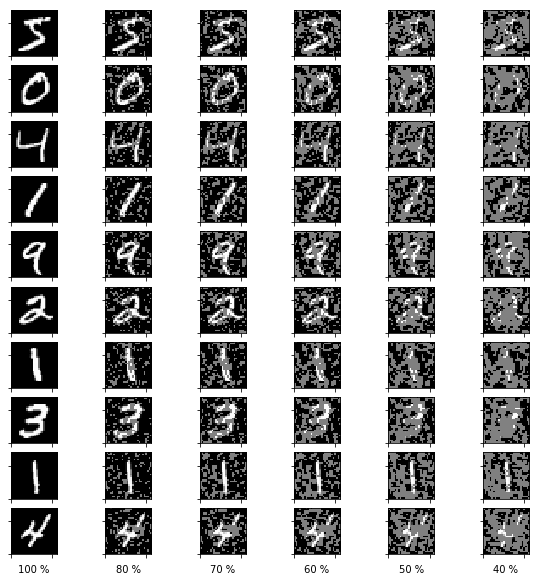

In [3]:
def showgrid(*cols, labels=None):
    n = cols[0].shape[0]
    cols = [c.reshape((n,height,width)) for c in cols]
    gs = plt.GridSpec(n,len(cols),wspace=0.1)
    for i,c in enumerate(cols):
        for j in range(n):
            ax = plt.subplot(gs[i+j*len(cols)])
            ax.imshow(c[j], cmap='gray',extent=(0,c.shape[2],0,c.shape[1]))
            if labels is not None and j == n-1:
                ax.set_xlabel(labels[i])
            ax.set_yticklabels([])
            ax.set_xticklabels([])

# uglier but quicker: display an entire column at a time
def showgrid2(*cols, labels=None):
    n = cols[0].shape[0]
    cols = [c.reshape((n*height,width)) for c in cols]
    gs = plt.GridSpec(1,len(cols),wspace=0.1)
    for i,c in enumerate(cols):
        ax = plt.subplot(gs[i])
        ax.imshow(c, cmap='gray',extent=(0,c.shape[1],0,c.shape[0]))
        for r in range(1,n):
            plt.plot([0,width], [r*height, r*height], color='y', linestyle='-', linewidth=1)
        ax.set_xlabel(labels[i])
        ax.set_yticklabels([])
        ax.set_xticklabels([])

x,m = xtrain[:10], masks_train[:10]
labels = ["100 %"] + [str(int(l*100))+" %" for l in levels[::-1]]
plt.figure(1,figsize=(10,10))
showgrid(x, *[x*(m <= i)+0.5*(m > i) for i in range(len(levels)-1,-1,-1)], labels=labels)

We define a class `MaskVAE` that implements a variational autoencoded with masked output. Most functionality we need already exists in keras, but we need to add the Gaussian activation in the $z$ layer as well as the VAE-specific loss function (with the mask modification).

In [4]:
@Lambda
def gaussReparam(args):
    mean, std = args
    return mean +  std* K.random_normal(shape=K.shape(mean),
                                        mean=0.0,
                                        stddev=1.0)
class MaskVAE:
    def __init__(self,nh,nz):
        reg_l2 = regularizers.l2(1e-4)
        self.g_hlayer = Dense(nh, activation='relu', kernel_regularizer=reg_l2)
        self.g_xlayer = Dense(ni, activation='sigmoid', kernel_regularizer=reg_l2)

        self.i_hlayer = Dense(nh, activation='relu', kernel_regularizer=reg_l2)
        self.i_mzlayer = Dense(nz, activation='linear', kernel_regularizer=reg_l2)
        self.i_szlayer = Dense(nz, activation='softplus', kernel_regularizer=reg_l2, kernel_initializer='zeros')

    def generator(self,z):
        h = self.g_hlayer(z)
        x = self.g_xlayer(h)
        return x

    def inference(self,xin,deterministic=False):
        h = self.i_hlayer(xin)
        mean_z = self.i_mzlayer(h)
        std_z = self.i_szlayer(h)
        z = gaussReparam([mean_z, std_z])
        code_cost = -0.5*K.sum(1+2*K.log(std_z)-mean_z**2-std_z**2,axis=1)
        return z, code_cost

    def compile(self,optimizer='adam'):

        xin = Input(shape=(ni,), name="x")
        xmask = Input(shape=(ni,), name="xmask")

        z, code_cost = self.inference(xin)
        xrecon = self.generator(z)
        self.model = Model([xin, xmask], xrecon)

        def vae_loss(xtrue,xpred):
            masked_loss = K.sum(K.binary_crossentropy(xtrue,xrecon)*xmask,axis=1)
            return K.mean(code_cost+masked_loss)

        def total_error(xtrue,xpred):
            total_loss = K.sum(K.binary_crossentropy(xtrue,xrecon),axis=1)
            return K.mean(total_loss)

        def kl_code(*a):
            return K.mean(code_cost)

        self.model.compile(loss=vae_loss,optimizer=optimizer, metrics=[total_error, kl_code])

We define a helper function to display inputs and outputs of the network. For a sets of input, it will send in masked values, and sample 5 reconstructions. For each reconstruction we send the value through the network two times, and show the output after both the first and second iteration.

In [5]:
def showrecon(vae, xshow, mshow):
    nsamp = 5
    xmshow = xshow*mshow + 0.5*(1-mshow)
    # As the autoencoder is indeterministic, repeat the process:
    xin = xshow*mshow +xmean[None,:] *(1-mshow)
    yshows = [vae.model.predict([xin,mshow]) for _ in range(nsamp)]
    yshows2 = [vae.model.predict([xshow*mshow+ys*(1-mshow),mshow]) for ys in yshows]

    ymix = list(chain(*zip(yshows,yshows2)))
    labels = ["original", "masked"] + nsamp * ["1 iter", "2 iters"]
    showgrid2(xshow,xmshow,*ymix,labels=labels)

## Training and evaluating a VAE model

We can now train an example model, the following uses 50% visible data, and 20 $z$ feature dimensions.
With GPU acceleration this should take a minute or two. Without GPU, if this takes to long time, feel free to skip this cell (pre-trained models will be loaded below)

In [6]:
%%time
j = 1
print("visibility level:", levels[j])
mtrain = 1*(masks_train <= j)
mvalid = 1*(masks_valid <= j)

vae = MaskVAE(ni,20)
adam = Adam(lr=0.002)
vae.compile(adam)
xmasked = xtrain*mtrain+ xmean[None,:]*(1-mtrain)
vae.model.fit([xmasked,mtrain],xtrain,epochs=40,batch_size=200)

visibility level: 0.5
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/40
60000/60000 [==============================] - 4s 72us/step - loss: 85.8647 - total_error: 168.1773 - kl_code: 8.3011
Epoch 2/40
60000/60000 [==============================] - 3s 51us/step - loss: 69.7651 - total_error: 131.8502 - kl_code: 12.0650
Epoch 3/40
60000/60000 [==============================] - 3s 52us/step - loss: 67.3116 - total_error: 124.8910 - kl_code: 12.9532
Epoch 4/40
60000/60000 [==============================] - 3s 52us/step - loss: 66.2846 - total_error: 121.8090 - kl_code: 13.3154
Epoch 5/40
60000/60000 [==============================] - 3s 52us/step - loss: 65.6080 - total_error: 119.6947 - kl_code: 13.5535
Epoch 6/40
60000/60000 [==============================] - 3s 52us/step - loss: 65.1260 - total_error: 118.2076 - kl_code: 13.7079
Epoch 7/40
60000/60000 [=============================

Now we can check how well the model works on the valitation set. If interactive widgets are activated, it is possible to explore the first 400 examples in the validation set.

In [7]:
def theplot(index):
    xshow = xvalid[index*10:(index+1)*10]
    mshow = mvalid[index*10:(index+1)*10]
    plt.figure(1,figsize=(10,10))
    showrecon(vae,xshow,mshow)
    plt.show()

index = IntSlider(min=0,max=40-1,step=1,value=0, continous_update=False)
interact(theplot, index=index)

<function theplot at 0x7f1c062216a8>

Now we can train multiple models, on different visibility levels as well as with different network parameters. Due to timing constraints, only one parameter is varied, the feature vector size. In production use more parameters would need to be varied, such as hidden layer size (here fixed to input size), number of hidden layers as well as regularization.

Training all the parameters would take quite a bit of time, especially without GPU acceleration. Therefore with this notebook, a set of pre-trained models are included and loaded by default. By setting `dotrain` to true, these can be reproduced (this takes roughly half an hour with GPU, probably several hours without GPU).

In [9]:
%%time
dotrain = False

nz_s = [2,3,5,10,20,50]
#nz_s = [2,5,20,50]
lvls = list(enumerate(levels))
models = {}
for nz in nz_s:
    for j,lvl in lvls:
        fn = "vae_models/vae_{}_{}.npy".format(nz,j)
        mtrain = 1*(masks_train <= j)

        vae = MaskVAE(ni,nz)
        adam = Adam(lr=0.002,decay=0.001)
        vae.compile(adam)
        if dotrain:
            vae.model.fit([xmasked,mtrain],xtrain,epochs=20,batch_size=200)
            vae.model.save_weights(fn)
        else:
            vae.model.load_weights(fn)
        models[nz,j] = vae

        xmasked = xtrain*mtrain+ xmean[None,:]*(1-mtrain)

CPU times: user 20.9 s, sys: 2.88 s, total: 23.8 s
Wall time: 23.7 s


We can now use interactive widgets to explore the dataset as well as parameter variation. Note we can vary the visibility level of the validation set (`valid_level`) independently of the training set used to train the model (`train_level`). For instance this can be used to check the robustness of the model, if the model can handle inputs with different visibility than it was trained on. Not that the reconstructed images come in pairs: after one and two iterations trough the autoencoder, respectively.

In [10]:
def theplot(index,nz,train_level,valid_level):
    tj = levels.index(train_level)
    vj = levels.index(valid_level)
    xshow = xvalid[index*10:(index+1)*10]
    mshow = 1*(masks_valid[index*10:(index+1)*10] <= vj)
    vae = models[nz,tj]
    plt.figure(1,figsize=(10,10))
    showrecon(vae,xshow,mshow)
    plt.show()

index = IntSlider(min=0,max=40-1,step=1,value=0, continous_update=False)
nzi = SelectionSlider(options=nz_s,value=20)
level = SelectionSlider(options=levels, value=0.5)
level2 = SelectionSlider(options=levels, value=0.5)
index = IntSlider(min=0,max=40-1,step=1,value=0, continous_update=False)
interact(theplot, nz=nzi, train_level=level, valid_level=level2, index=index)

<function theplot at 0x7f1c06958e18>

## Performance evaluation

As a direct performance measure we can use the MSE (mean square error) of the validation set under the model.

In [11]:
def log_mean_exp(logl, axis=-1):
    maxv = logl.max(axis=axis,keepdims=True)
    ivals = np.log(np.mean(np.exp(logl-maxv), axis=axis))
    vals=ivals+np.squeeze(maxv,axis=axis)
    return vals

nz_test = [2,3,5,10,20,50]
ntries = 5
scores = np.zeros((len(nz_s), len(lvls), 2))
for i,nz in enumerate(nz_s):
    for j,lvl in lvls:
        vae = models[nz,j]
        mask = 1*(masks_valid <= j)
        logls = np.zeros((2,nvalid,ntries))
        for k in range(ntries):
            xin = xvalid*mask+xmean[None,:]*(1-mask)
            y = vae.model.predict([xin,mask], batch_size=512)
            xin = xvalid*mask+y*(1-mask)
            y2 = vae.model.predict([xin,mask], batch_size=512)
            logls[:,:,k] = [-((yi-xvalid)**2*(1-mask)).sum(axis=1)/2 for yi in [y,y2]]
        # MSE is a (negative) log-likelihood measure, average it as such
        logls = log_mean_exp(logls,axis=2)
        scores[i,j,:] = logls.mean(axis=1)

Here we plot the error as function of visibility level and feature layer size.

<<class 'matplotlib.legend.Legend'> at 0x7f1d6ba74f28>

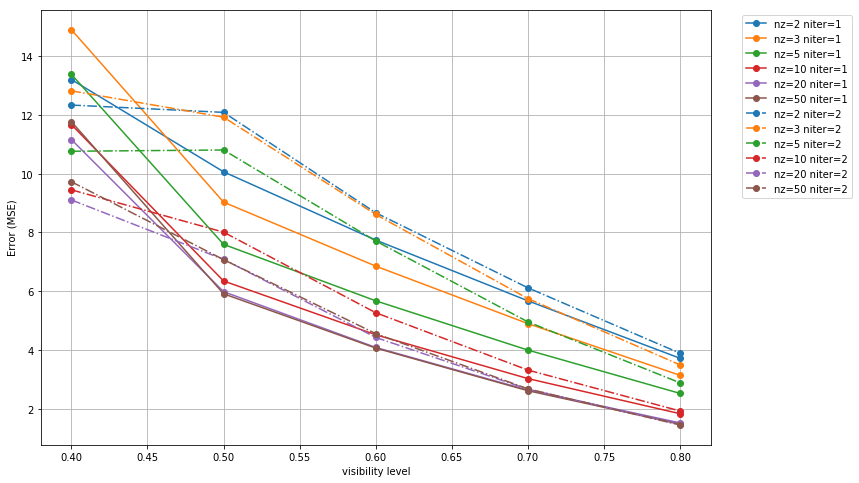

In [12]:
plt.figure(figsize=(12,8))
for nit in range(2):
    plt.gca().set_prop_cycle(None)
    for i,nz in enumerate(nz_s):
        plt.plot(levels,-scores[i,:,nit].T,'o-'+nit*'.',label='nz={} niter={}'.format(nz,nit+1))
plt.xlabel("visibility level")
plt.ylabel("Error (MSE)")
plt.grid()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Bigger feature layer gives better reconstruction, not surprisingly, but increasing over 20 dimensions does not improve much. A single iteration gives best reconstruction for 0.50 visibility and higher, however for 0.4 visibility two iterations are typically better. Two iteration performance could be improved by training the network using its own inputed values (mixed with correct available values) in addition to the simply mean imputed data.

As said initially, we are often not interested in the performance of the imputation model _per se_, rather it is a pre-processing step for an interesting target model. For MNIST, we can demonstrate this by training a classifier of the different digits, that uses the imputed values instead of the true values (which in a realistic application of course is not known!) 
We use multiple imputation in both training and evaluation. In training we sample new imputed values for each epoch, and in evaluation we average class probabilities over multiple imputations. As a score function we use the number of correctly classified examples, as determined by the averaged probabilities.

In [13]:
def evaluate(vae,j,niter=2):
    ntries = 5
    mtrain = 1*(masks_train <= j)
    mvalid = 1*(masks_valid <= j)
    mlp = Sequential([
        Dense(500,activation='relu',input_shape=(ni,)),
        Dense(10,activation='softmax'),
        ])
    adam = Adam(lr=0.005)
    mlp.compile(loss='sparse_categorical_crossentropy', optimizer=adam)
    for i in range(5):
        xin = xtrain*mtrain+xmean[None,:]*(1-mtrain)
        for _ in range(niter):
            ximp = vae.model.predict([xin,mtrain], batch_size=512)
            xin = xtrain*mtrain+ximp*(1-mtrain)
        mlp.fit(xin,ytrain,epochs=1, batch_size=512)

    outputs = []
    for i in range(ntries):
        xin = xvalid*mvalid+xmean[None,:]*(1-mvalid)
        for _ in range(niter):
            ximp = vae.model.predict([xin,mvalid], batch_size=512)
            xin = xvalid*mvalid+ximp*(1-mvalid)
        out = mlp.predict(xin)
        outputs.append(out)
    pred = np.mean(outputs,axis=0)
    best = pred.argmax(axis=1)
    score = (best == yvalid).mean()
    return score

#nz_c = [2,3,5,10,20,50]
nz_c= [5,10,50]
cscores = np.zeros((len(nz_c), len(lvls), 2))
for i,nz in enumerate(nz_c):
    for j,lvl in lvls:
        vae = models[nz,j]
        for k in range(2):
            cscores[i,j,k] = evaluate(vae,j,niter=k+1)
baseline = np.zeros(len(lvls))
for j,lvl in lvls:
    baseline[j] = evaluate(None,j,niter=0)
goldstandard = evaluate(None,len(levels),niter=0)

Epoch 1/1
60000/60000 [==============================] - 1s 17us/step - loss: 0.7847
Epoch 1/1
60000/60000 [==============================] - 1s 10us/step - loss: 0.5621
Epoch 1/1
60000/60000 [==============================] - 1s 11us/step - loss: 0.4944
Epoch 1/1
60000/60000 [==============================] - 1s 11us/step - loss: 0.4451
Epoch 1/1
60000/60000 [==============================] - 1s 11us/step - loss: 0.4087
Epoch 1/1
60000/60000 [==============================] - 1s 19us/step - loss: 0.7596
Epoch 1/1
60000/60000 [==============================] - 1s 10us/step - loss: 0.5614
Epoch 1/1
60000/60000 [==============================] - 1s 10us/step - loss: 0.5152
Epoch 1/1
60000/60000 [==============================] - 1s 11us/step - loss: 0.4660
Epoch 1/1
60000/60000 [==============================] - 1s 10us/step - loss: 0.4428
Epoch 1/1
60000/60000 [==============================] - 1s 17us/step - loss: 0.4628
Epoch 1/1
60000/60000 [==============================] - 1s 10us/

We plot the classification performance depending on the visibility level. As baseline we use mean imputation only. As a relative "gold standard" we train the same classification model with the complete dataset. (Of course, the true gold standard for MNIST is a lot better, but this is for the demonstration of the effect of missing data)

<<class 'matplotlib.legend.Legend'> at 0x7f1d5add55f8>

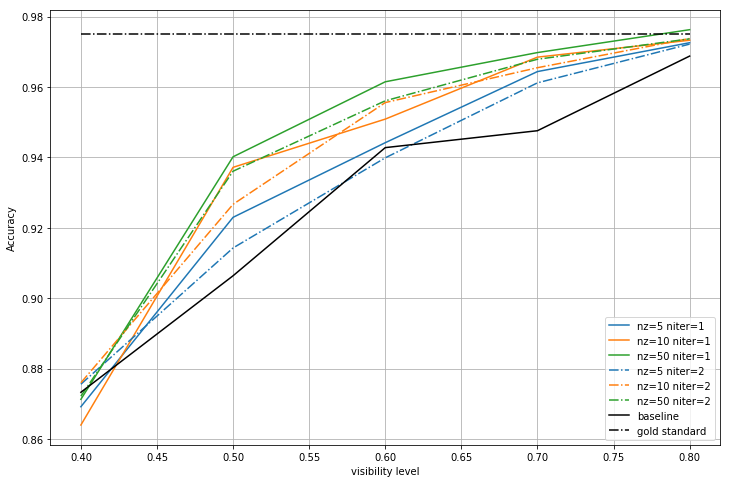

In [14]:
plt.figure(figsize=(12,8))
for nit in range(2):
    plt.gca().set_prop_cycle(None)
    for i,nz in enumerate(nz_c):
        plt.plot(levels,cscores[i,:,nit].T,'o-'+nit*'.',label='nz={} niter={}'.format(nz,nit+1))
plt.plot(levels,baseline,'k',label='baseline')
plt.plot([levels[0], levels[-1]],[goldstandard,goldstandard],'k-.', label='gold standard')
plt.xlabel("visibility level")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

We see a clear improvement over baseline, for visibility levels of 0.5 and over, but there is much room for improvement (by more complex network architectures, better training techniques). The fact that it  goes over the "gold standard" just indicates the standard really is not very good, rather than a mirace. Of course, comparison to state-of-art imputation methods like $k$-nearest neighbours, deterministic autoencoders and MICE should also be done, but I didn't have the time to do this in scope of this notebook project.